<a href="https://colab.research.google.com/github/avoca-dorable/NLP_handson/blob/main/CORAL_Ordinal_Examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ordinal classification in Tensorflow Keras 

This notebook uses MNIST hand-written digits and Amazon reviews as a examples of ordinal classification, using the coral-ordinal package for Tensorflow Keras.


**Acknowledgments**: This notebook is based in part on PyTorch source code written by Sebastian Rashka [in this notebook](https://github.com/Raschka-research-group/coral-cnn/blob/master/coral-implementation-recipe.ipynb).

## Installation

With pip you can either install the latest source code from GitHub or the stable version of the module on pypi.org

# View data
https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data

In [1]:
# Use Tensorflow 2.2 rather than 2.3 or a later version.
# To support TF 2.3 we need to try switching "convert_to_tensor_v2" to "convert_to_tensor" in loss.py
# Per https://github.com/ck37/coral-ordinal/issues/1
# !pip install -q tensorflow==2.2

# Install stable version from pypi.org
#!pip install coral-ordinal -q --force-reinstall --no-deps

# Install source package from GitHub
!pip install --force-reinstall --no-deps git+https://github.com/ck37/coral-ordinal/

  Cloning https://github.com/ck37/coral-ordinal/ to /tmp/pip-req-build-w386bvze
  Running command git clone -q https://github.com/ck37/coral-ordinal/ /tmp/pip-req-build-w386bvze
  Created wheel for coral-ordinal: filename=coral_ordinal-0.1.9.dev0-py3-none-any.whl size=14610 sha256=daa9a7b13ff7168a99fbd8f2ec791ad82a09489f861b6cf1075f6ed55489fddd
  Stored in directory: /tmp/pip-ephem-wheel-cache-qvv7_3vf/wheels/01/d9/85/8a6675507c6e6f1f9b890510f5b5ebd1fac5220ba0fc0893d7
Successfully built coral-ordinal


In [2]:
import tensorflow as tf
print("Tensorflow version", tf.__version__)

import coral_ordinal as coral
print("CORAL Ordinal version:", coral.__version__)

Tensorflow version 2.8.0
CORAL Ordinal version: 0.1.9.dev


## MNIST toy example

This outcome is not actually ordinal, it's categorical. We're just using it as a toy example to show how the different components are used.

In [3]:
##########################
### SETTINGS
##########################

# Hyperparameters
random_seed = 1 # Not yet used
learning_rate = 0.05
batch_size = 128
num_epochs = 2

# Architecture
NUM_CLASSES = 10

In [4]:
# Fetch and format the mnist data
(mnist_images, mnist_labels), (mnist_images_test, mnist_labels_test) = tf.keras.datasets.mnist.load_data()

# Split off a validation dataset for early stopping
from sklearn import model_selection
mnist_images, mnist_images_val, mnist_labels, mnist_labels_val = \
  model_selection.train_test_split(mnist_images, mnist_labels, test_size = 5000, random_state = 1)

print("Shape of training images:", mnist_images.shape)
print("Shape of training labels:", mnist_labels.shape)

print("Shape of test images:", mnist_images_test.shape)
print("Shape of test labels:", mnist_labels_test.shape)

print("Shape of validation images:", mnist_images_val.shape)
print("Shape of validation labels:", mnist_labels_val.shape)

# Also rescales to 0-1 range.
dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[..., tf.newaxis] / 255, tf.float32),
   tf.cast(mnist_labels, tf.int64)))
dataset = dataset.shuffle(1000).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images_test[..., tf.newaxis] / 255, tf.float32),
   tf.cast(mnist_labels_test, tf.int64)))
#test_dataset = test_dataset.shuffle(1000).batch(batch_size)
# Here we do not shuffle the test dataset.
test_dataset = test_dataset.batch(batch_size)


val_dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images_val[..., tf.newaxis] / 255, tf.float32),
   tf.cast(mnist_labels_val, tf.int64)))
val_dataset = val_dataset.shuffle(1000).batch(batch_size)

11501568/11490434 [==============================] - 0s 0us/step
Shape of training images: (55000, 28, 28)
Shape of training labels: (55000,)
Shape of test images: (10000, 28, 28)
Shape of test labels: (10000,)
Shape of validation images: (5000, 28, 28)
Shape of validation labels: (5000,)


### Simple MLP model



Now we create a simple multi-layer perceptron model so that we can apply the ordinal output layer.

In [5]:
def create_model(num_classes):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape = (28, 28, )))
  model.add(tf.keras.layers.Dense(128, activation = "relu"))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(32, activation = "relu"))
  model.add(tf.keras.layers.Dropout(0.1))
  # Ordinal output layer with a certain number of classes / ranks / labels.
  # No activation function specified so this will output cumulative logits.
  model.add(coral.CoralOrdinal(num_classes))
  return model

model = create_model(NUM_CLASSES)

# Note that the model generates 1 fewer outputs than the number of classes. 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 coral_ordinal (CoralOrdinal  (None, 9)                41        
 )                                                               
                                                        

In [6]:
# Or a functional API version
def create_model2(num_classes):
  inputs = tf.keras.Input(shape = (28, 28, ))

  x = tf.keras.layers.Flatten()(inputs)
  x = tf.keras.layers.Dense(128, activation = "relu")(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(32, activation = "relu")(x)
  x = tf.keras.layers.Dropout(0.1)(x)

  # Ordinal output layer with a certain number of classes / ranks / labels.
  # No activation function specified so this will output cumulative logits.
  outputs = coral.CoralOrdinal(num_classes)(x)

  model = tf.keras.Model(inputs = inputs, outputs = outputs)

  return model

model = create_model2(NUM_CLASSES)

# Note that the model generates 1 fewer outputs than the number of classes. 
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               100480    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 32)                4128      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 coral_ordinal_1 (CoralOrdin  (None, 9)                41    

In [7]:
model.compile(optimizer = tf.keras.optimizers.Adam(lr = learning_rate),
              loss = coral.OrdinalCrossEntropy(num_classes = NUM_CLASSES),
              metrics = [coral.MeanAbsoluteErrorLabels()])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [8]:
%%time

# This takes about 5 minutes on CPU, 2.5 minutes on GPU.
history = model.fit(dataset, epochs = 5, validation_data = val_dataset,
                    callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)])

Epoch 1/5
430/430 [==============================] - 7s 6ms/step - loss: 3.6455 - mean_absolute_error_labels: 1.5000 - val_loss: 2.3776 - val_mean_absolute_error_labels: 0.9377
Epoch 2/5
430/430 [==============================] - 2s 5ms/step - loss: 2.3902 - mean_absolute_error_labels: 0.9588 - val_loss: 1.9511 - val_mean_absolute_error_labels: 0.6676
Epoch 3/5
430/430 [==============================] - 2s 5ms/step - loss: 2.1756 - mean_absolute_error_labels: 0.8211 - val_loss: 1.7845 - val_mean_absolute_error_labels: 0.5980
Epoch 4/5
430/430 [==============================] - 2s 5ms/step - loss: 2.0754 - mean_absolute_error_labels: 0.7800 - val_loss: 1.8114 - val_mean_absolute_error_labels: 0.6420
Epoch 5/5
430/430 [==============================] - 2s 6ms/step - loss: 2.0872 - mean_absolute_error_labels: 0.7875 - val_loss: 1.7461 - val_mean_absolute_error_labels: 0.5586
CPU times: user 17.4 s, sys: 2.37 s, total: 19.7 s
Wall time: 22.3 s


### Test set evaluation

In [9]:
# Evaluate on test dataset.
model.evaluate(test_dataset)

79/79 [==============================] - 0s 4ms/step - loss: 1.7228 - mean_absolute_error_labels: 0.5466


[1.7227572202682495, 0.5465783476829529]

In [15]:
# list(test_dataset.as_numpy_iterator())[0]

### Cumulative logits to probabilities

We can convert the cumulative logit output of the layer into the probability estimate for each ordinal label. This can then be used to calculate other metrics like accuracy or mean absolute error.

Notice that the probability distribution for each observation is unimodal, which is what we want for an ordinal outcome variable.

In [16]:
import pandas as pd

print("Predict on test dataset")

# Note that these are ordinal (cumulative) logits, not probabilities or regular logits.
ordinal_logits = model.predict(test_dataset)

# Convert from logits to label probabilities. This is initially a tensorflow tensor.
tensor_probs = coral.ordinal_softmax(ordinal_logits)

# Convert the tensor into a pandas dataframe.
probs_df = pd.DataFrame(tensor_probs.numpy())

probs_df.head()

Predict on test dataset


,0,1,2,3,4,5,6,7,8,9
0,0.000002,0.000639,3.687680e-03,1.130116e-02,2.431327e-02,4.502517e-02,1.225838e-01,2.842679e-01,3.513567e-01,1.568233e-01
1,0.000927,0.219075,4.366043e-01,2.181347e-01,7.344209e-02,2.791687e-02,1.529375e-02,6.262463e-03,1.921075e-03,4.226996e-04
2,0.022289,0.851616,1.052545e-01,1.504655e-02,3.574800e-03,1.223628e-03,6.423246e-04,2.575669e-04,7.839075e-05,1.720976e-05
3,0.999969,0.000031,8.642356e-08,1.085965e-08,2.531914e-09,8.624932e-10,4.519073e-10,1.810481e-10,5.508360e-11,1.209181e-11
4,0.000060,0.017802,9.189916e-02,2.007258e-01,2.307799e-01,1.835133e-01,1.565654e-01,8.350112e-02,2.863754e-02,6.515471e-03


In [ ]:
# Check that probabilities all sum to 1 - looks good!
probs_df.sum(axis = 1)

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
9995    1.0
9996    1.0
9997    1.0
9998    1.0
9999    1.0
Length: 10000, dtype: float32

### Label prediction

This notebook shows two ways of calculating predicted labels. We can take the highest probability label (first method) or we can choose the highest label with Pr(Y > label) > 50%.

In [17]:
# Probs to labels
labels = probs_df.idxmax(axis = 1)
labels.values

array([8, 2, 1, ..., 4, 6, 6])

In [18]:
import numpy as np
# What is our accuracy? Around 64%.
np.mean(labels == mnist_labels_test)

0.606

In [ ]:
from scipy import special

# Compare to logit-based cumulative probs
cum_probs = pd.DataFrame(ordinal_logits).apply(special.expit)
cum_probs.head()

,0,1,2,3,4,5,6,7,8
0,0.999980,0.997417,0.985583,9.466467e-01,8.770849e-01,7.482002e-01,5.185375e-01,2.242754e-01,4.152207e-02
1,0.998893,0.871811,0.546330,2.381226e-01,1.116614e-01,4.973859e-02,1.861846e-02,5.067059e-03,7.625239e-04
2,0.994172,0.562448,0.185410,5.577876e-02,2.320635e-02,9.796135e-03,3.572982e-03,9.616650e-04,1.442121e-04
3,0.000886,0.000007,0.000001,3.069660e-07,1.234523e-07,5.140741e-08,1.863292e-08,5.001923e-09,7.494793e-10
4,0.999716,0.963607,0.824205,5.489042e-01,3.285749e-01,1.692839e-01,6.878123e-02,1.944230e-02,2.962163e-03


Now we should try another option, which is used in the Cao et al. paper.

In [ ]:
# Calculate the labels using the style of Cao et al.
labels2 = cum_probs.apply(lambda x: x > 0.5).sum(axis = 1)
labels2.head()

0    7
1    3
2    2
3    0
4    4
dtype: int64

In [ ]:
# What is the accuracy of these labels? About 66%.
np.mean(labels2 == mnist_labels_test)

0.5815

In [ ]:
# More often than not these are the same, but still a lot of discrepancy.
np.mean(labels == labels2)

0.6844

In [ ]:
print("Mean absolute label error version 1:", np.mean(np.abs(labels - mnist_labels_test)))
print("Mean absolute label error version 2:", np.mean(np.abs(labels2 - mnist_labels_test)))

Mean absolute label error version 1: 0.6596
Mean absolute label error version 2: 0.5864


In [ ]:
mnist_labels_test[:5]

array([7, 2, 1, 0, 4], dtype=uint8)

In [ ]:
# The output layer is the last layer in the model.
last_layer = len(model.layers) - 1

# Check bias terms: these should be in descending order.
model.layers[last_layer].get_weights()[1]

array([ 8.1811285 ,  3.2930422 ,  1.5618263 ,  0.21297182, -0.6979102 ,
       -1.5739838 , -2.588836  , -3.903943  , -5.8021417 ], dtype=float32)

Plot the bias terms to visually confirm that they are monotonically descending.

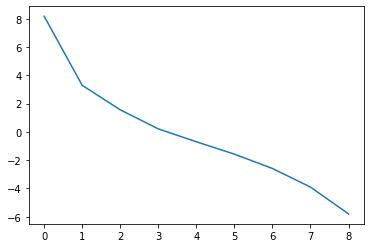

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(model.layers[last_layer].get_weights()[1])
plt.show()

### Importance weights customization

A quick example to show how the importance weights can be customized. One might want to use the formula from the paper to more thoroughly calculate customized weights.

In [ ]:
model = create_model(num_classes = NUM_CLASSES)
model.summary()

# We have num_classes - 1 outputs (cumulative logits), so there are 9 elements
# in the importance vector to customize.
importance_weights = [1., 1., 0.5, 0.5, 0.5, 1., 1., 0.1, 0.1]
loss_fn = coral.OrdinalCrossEntropy(NUM_CLASSES, importance_weights = importance_weights)

model.compile(tf.keras.optimizers.Adam(lr = learning_rate), loss = loss_fn)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
coral_ordinal_2 (CoralOrdina (None, 9)                 41        
Total params: 104,649
Trainable params: 104,649
Non-trainable params: 0
________________________________________________

In [ ]:
%%time

history = model.fit(dataset, epochs = num_epochs)

Epoch 1/2
430/430 [==============================] - 20s 44ms/step - loss: 3.9555
Epoch 2/2
430/430 [==============================] - 19s 44ms/step - loss: 1.4824
CPU times: user 57.9 s, sys: 9.56 s, total: 1min 7s
Wall time: 39 s


## Amazon reviews and 5-star ratings

Amazon review data via https://nijianmo.github.io/amazon/index.html#subsets


In [19]:
!wget -qq http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Prime_Pantry_5.json.gz 

In [20]:
import tensorflow_hub as hub
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen
import numpy as np


data = []
with gzip.open('Prime_Pantry_5.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

df = pd.DataFrame.from_dict(data)
df = df[['overall', 'reviewText']]

# There is a large amount of duplicate text in here, possibly due to paid/fraudulent reviews.
df.drop_duplicates("reviewText", inplace = True)

# Some of the text is blank, which causes an obscure error about floating point conversion.
df.dropna(inplace = True)

print(len(df))
print(df.head())

outcome_col = "overall"
text_col = "reviewText"

# We subtract the minimum value from the outcomes so that they start at 0.
df[outcome_col] = df[outcome_col].values - df[outcome_col].min()

print("\n", df.overall.value_counts())

# TODO: define automatically based on the number of unique values in the outcome variable.
num_classes = 5

99025
   overall                                         reviewText
0      4.0  I purchased this Saran premium plastic wrap af...
1      5.0  I am an avid cook and baker.  Saran Premium Pl...
2      5.0  Good wrap, keeping it in the fridge makes it e...
3      4.0  I prefer Saran wrap over other brands. It does...
4      5.0                                             Thanks

 4.0    69812
3.0    15294
2.0     7664
1.0     3342
0.0     2913
Name: overall, dtype: int64


In [21]:
# Train/Test split
from sklearn.model_selection import train_test_split
text_train, text_test, labels_train, labels_test = \
  train_test_split(df[text_col].values, df[outcome_col].values, test_size = 10000, random_state = 1)

print("Training text shape:", text_train.shape)
print("Training labels shape:", labels_train.shape)
print("Testing text shape:", text_test.shape)
print("Testing labels shape:", labels_test.shape)

Training text shape: (89025,)
Training labels shape: (89025,)
Testing text shape: (10000,)
Testing labels shape: (10000,)


### Universal Sentence Encoder model

In [22]:
%%time
# This takes 20 - 30 seconds.

import tensorflow as tf

# Clear our GPU memory to stay efficient.
tf.keras.backend.clear_session()

input_text = tf.keras.layers.Input(shape = [], dtype = tf.string, name = 'input_text')

model_url = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

base_model = hub.KerasLayer(model_url, input_shape = [],
                            dtype = tf.string,
                            trainable = False)
                            
embedded = base_model(input_text)

x = tf.keras.layers.Dense(64, activation = 'relu')(embedded)
x = tf.keras.layers.Dropout(0.1)(x)
output = coral.CoralOrdinal(num_classes)(x) 

model = tf.keras.Model(inputs = input_text, outputs = output)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_text (InputLayer)     [(None,)]                 0         
                                                                 
 keras_layer (KerasLayer)    (None, 512)               147354880 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 coral_ordinal (CoralOrdinal  (None, 4)                68        
 )                                                               
                                                                 
Total params: 147,387,780
Trainable params: 32,900
Non-trainable params: 147,354,880
__________________________________________

In [23]:
model.compile(loss = coral.OrdinalCrossEntropy(num_classes),
              metrics = [coral.MeanAbsoluteErrorLabels()],
              optimizer = tf.keras.optimizers.Adam(lr = 0.001))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [24]:
# Encode a test string and take a look at the first ten dimensions.
base_model(np.array(["test_string"])).numpy()[0, :10]

array([-0.01035028,  0.00395392, -0.04288317,  0.0048328 , -0.07732296,
       -0.06699762,  0.01624425, -0.01737378, -0.00085807,  0.01084492],
      dtype=float32)

In [ ]:
%%time

history = model.fit(x = text_train,
                    y = labels_train,
                    epochs = 5,
                    # 128 and 512 cause out-of-memory errors. But strange that it happens after ~10 epochs.
                    batch_size = 32, 
                    validation_split = 0.2,
                    callbacks = [tf.keras.callbacks.EarlyStopping(patience = 2,
                                                                  min_delta = 0.001,
                                                                  restore_best_weights = True)])

Epoch 1/5
2224/2226 [============================>.] - ETA: 0s - loss: 1.0067 - mean_absolute_error_labels: 0.3948

### Evaluate

In [ ]:
model.evaluate(text_test, labels_test)

313/313 [==============================] - 21s 66ms/step - loss: 0.7962 - mean_absolute_error_labels: 0.3195


[0.7962134480476379, 0.3194888234138489]

In [ ]:
# Generate predictions - initially these are cumulative logits.
preds = model.predict(text_test)
print(preds)
# Convert cumulative logits to probabilities for each class aka rank or label.
probs = pd.DataFrame(coral.ordinal_softmax(preds).numpy())

[[ 8.118758    6.815898    5.2418857   3.5594192 ]
 [ 4.1327972   2.829937    1.2559245  -0.4265418 ]
 [ 6.450637    5.147777    3.5737643   1.8912982 ]
 ...
 [ 4.368989    3.066129    1.4921162  -0.19034994]
 [ 6.744893    5.442033    3.8680203   2.185554  ]
 [ 7.300754    5.9978943   4.4238815   2.741415  ]]


In [ ]:
print(probs.head(10))
print(labels_test[:10])

          0         1         2         3         4
0  0.000298  0.000797  0.004167  0.022406  0.972332
1  0.015785  0.039943  0.165949  0.383371  0.394952
2  0.001577  0.004202  0.021506  0.103812  0.868903
3  0.009369  0.024264  0.110174  0.330825  0.525368
4  0.004581  0.012073  0.058905  0.229821  0.694620
5  0.000422  0.001130  0.005892  0.031333  0.961223
6  0.000875  0.002337  0.012099  0.061866  0.922824
7  0.371062  0.313582  0.228227  0.069693  0.017435
8  0.003381  0.008949  0.044496  0.187928  0.755245
9  0.001191  0.003179  0.016373  0.081541  0.897715
[4. 1. 4. 2. 4. 4. 4. 1. 4. 4.]


### Evaluate accuracy

In [ ]:
# Evaluate accuracy and mean absolute error
labels_v1 = probs.idxmax(axis = 1)
print("Accuracy of label version 1:", np.mean(labels_v1 == labels_test))

from scipy import special

# Compare to logit-based cumulative probs
cum_probs = pd.DataFrame(preds).apply(special.expit)
# Calculate the labels using the style of Cao et al.
labels_v2 = cum_probs.apply(lambda x: x > 0.5).sum(axis = 1)
print("Accuracy of label version 2:", np.mean(labels_v2 == labels_test))

Accuracy of label version 1: 0.7454
Accuracy of label version 2: 0.74


### Evaluate mean absolute label error

This is effectively an ordinal version of 1 - accuracy.

In [ ]:
# These do not correspond with what we get from the model evaluation. Something must be off in one of these.
print("Mean absolute label error version 1:", np.mean(np.abs(labels_v1 - labels_test)))
print("Mean absolute label error version 2:", np.mean(np.abs(labels_v2 - labels_test)))

print("Root mean squared label error version 1:", np.sqrt(np.mean(np.square(labels_v1 - labels_test))))
print("Root mean squared label error version 2:", np.sqrt(np.mean(np.square(labels_v2 - labels_test))))

Mean absolute label error version 1: 0.3286
Mean absolute label error version 2: 0.3197
Root mean squared label error version 1: 0.7128814768248646
Root mean squared label error version 2: 0.6803675477269621


In [ ]:
# Review how absolute error is calculated for ordinal labels:
pd.DataFrame({"true": labels_test, "pred_v2": labels_v1, "abs": labels_v2 - labels_test}).head()

,true,pred_v2,abs
0,4.0,4,0.0
1,1.0,4,2.0
2,4.0,4,0.0
3,2.0,4,2.0
4,4.0,4,0.0
